In [4]:
import optuna
import pickle
import torch
import os
import sys
import ROOT
import numpy as np
import matplotlib.pyplot as plt

# Add the root folder to Python path
root_folder = os.path.abspath(os.path.join(os.getcwd(), ".."))
if root_folder not in sys.path:
    sys.path.append(root_folder)

import lib.unet_nn as UNet
import lib.modified_aggregation as MA
from lib.focal import FocalH
from lib.base_nn import Data
from lib.metrics import count_clusters, count_labels

/home/bjartur/miniconda3/envs/focalh/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Study overview

In [26]:
study_file = "../studies/study_ma_25082025_160132.pkl"
with open(study_file, "rb") as f:
    loaded_bundle = pickle.load(f)
print(f"bundle: \n{loaded_bundle}")
print()
print(f"study: {loaded_bundle['study'].best_params}")


bundle: 
{'method': {'name': 'ma', 'parameters': [{'name': 'seed', 'type': 'float', 'min': 0, 'max': 4096}, {'name': 'agg', 'type': 'float', 'min': 0, 'max': 4096}]}, 'study': <optuna.study.study.Study object at 0x774d8872fdd0>, 'data': {'name': 'small test set', 'files': [{'path': 'data/E150_P5_N1000.root', 'particles': 5, 'saturation': 4096, 'meta': {'source': 'mc', 'detector': 'prototype2'}}, {'path': 'data/E150_P3_N1000.root', 'particles': 3, 'saturation': 4096, 'meta': {'source': 'mc', 'detector': 'prototype2'}}]}, 'its': 1}

study: {'seed': 3711.0433715907297, 'agg': 2125.014619264346}


In [15]:
def lst_test(par1=None, par2=None, par3=None):
    print(f"par1: {par1}")
    print(f"par2: {par2}")
    print(f"par3: {par3}")
lst = ["adsf", "bla"]
lst_test(*lst)

par1: adsf
par2: bla
par3: None


# Evaluate studies

In [2]:
ma_study_file = "../studies/study_ma_24082025_133543.pkl"

cnn_study_file = "../studies/study_cnn_24082025_132142.pkl"
cnn_model_file = "../studies/model_cnn_24082025_132142.pt"

In [65]:
with open(ma_study_file, "rb") as f:
    loaded_bundle = pickle.load(f)
ma_study = loaded_bundle
ma = MA.ModifiedAggregation(ma_study["study"].best_params["seed"], ma_study["study"].best_params["agg"])
#ma = MA.ModifiedAggregation(1400, 0)
ma_study["exec"] = ma
ma_study["study"].best_params

{'seed': 1228.8304533067371, 'agg': 814.8197992366731}

In [4]:
with open(cnn_study_file, "rb") as f:
    loaded_bundle = pickle.load(f)
u = torch.load(cnn_model_file, weights_only=False)
cnn_study = loaded_bundle
cnn_study["exec"] = u
cnn_study["study"].best_params

{'seed': 0.5,
 'agg': 0.0,
 'lr': 0.5625913914829032,
 'momentum': 0.841114016126484,
 'epochs': 92}

9637.0
4095.0


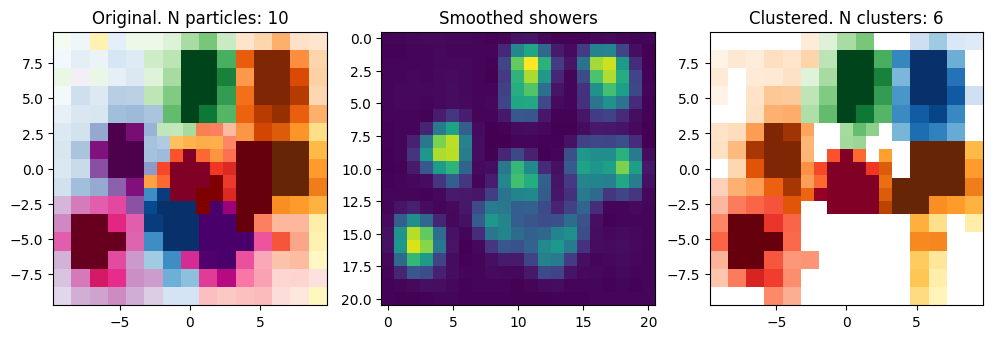

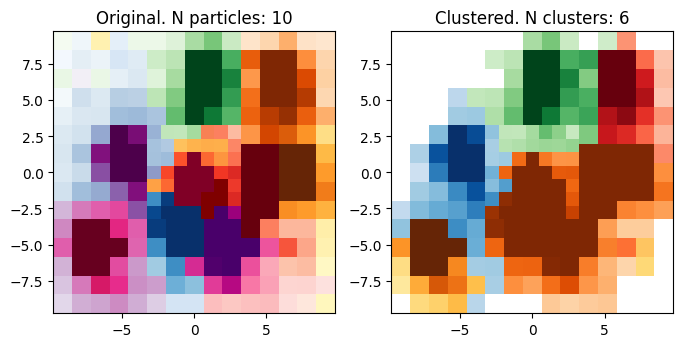

In [75]:
def cluster_event(tfile, entry, study):
    """
    Just try clustering an event and view it.
    """
#    study["exec"]

    SAT = 4096
    tfile = ROOT.TFile(tfile, "READ")
    ttree = tfile.Get("EventsTree")
    ttree.GetEntry(entry)

    nplab = np.array(ttree.labels, dtype=np.int32)
    npfrac = np.array(ttree.fractions, dtype=np.float32)
    npvals = np.array(ttree.value, dtype=np.float32)
    valmask = npvals > SAT
    npvals[valmask] = SAT
    particles = len(set(nplab))
    
    dataloader = Data()
    npdlab = dataloader.get_major_labels(nplab, npfrac, particles)




    if study["method"] == "ma":
        iadj = np.load("../p2_sim_adj_map2.npy")
        adj = np.load("../p2_adj.npy")
        fig, ax = plt.subplots(ncols=2, figsize=(8,4))        
        foc = FocalH()
        foc.heatmap(npvals[iadj], npdlab[iadj], ax[0], SAT)
        clabels,_ = study["exec"].run(adj, npvals[iadj])
        foc.heatmap(npvals[iadj], clabels, ax[1], SAT)
        ax[0].set_title(f"Original. N particles: {count_labels(npdlab)}")
        ax[1].set_title(f"Clustered. N clusters: {count_clusters(clabels)}")

        fig.savefig(study["method"]+"_P"+str(particles)+"_EV"+str(entry))
            
    elif study["method"] == "cnn":
        iadj = np.load("../p2_sim_adj_map2.npy")
        adj = np.load("../p2_image_adj_21x21.npy")
        fig, ax = plt.subplots(ncols=3, figsize=(12,4))        
        foc = FocalH()
        foc.heatmap(npvals[iadj], npdlab[iadj], ax[0], SAT)
        ret, coms, dlabels, mapping = dataloader.read_ttree_event(ttree, entry)
        #target = dataloader.gaussian_class_activation_map(coms, 21, 21, 3)[0][0]

        x = study["exec"](ret)[0][0]
        vals = x.flatten().detach().numpy()
#        vals = vals / vals.max()
        ax[1].imshow(x.detach().numpy())

        seed = study["study"].best_params["seed"]
        agg = study["study"].best_params["agg"]
        clusterizer = MA.ModifiedAggregation(seed,agg)
#        clusterizer = MA.ModifiedAggregation(0.45,0)
        clabels,_ = clusterizer.run(adj,vals)

        clabels = dataloader.invert_labels(clabels, mapping, vals, npdlab.shape[0])
#        print(vals.max())
        foc.heatmap(npvals[iadj], clabels.astype(np.int32), ax[2], SAT)
        ax[0].set_title(f"Original. N particles: {count_labels(npdlab)}")
        ax[1].set_title(f"Smoothed showers")
        ax[2].set_title(f"Clustered. N clusters: {count_clusters(clabels)}")

        fig.savefig(study["method"]+"_P"+str(particles)+"_EV"+str(entry))

        

    
    

    
filename = "/home/bjartur/workspace/python_focalh_clustering/data/E300_P10_N1000.root"
entry = 100
cluster_event(filename, entry, cnn_study)
cluster_event(filename, entry, ma_study)

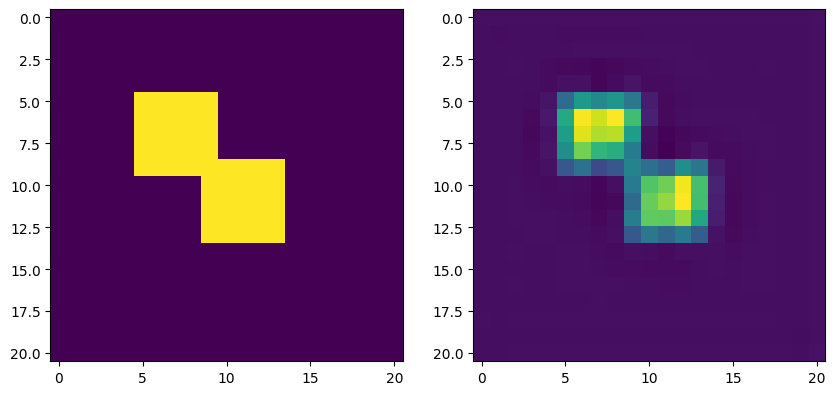

In [47]:
x_synth = np.zeros(21*21, dtype=np.float32).reshape(21,21)

fig,ax=plt.subplots(ncols=2, figsize=(10,5))

size=5
c1 = (9,9)
b1 = slice(c1[0],c1[0]+size), slice(c1[1],c1[1]+size)


c2 = (5,5)
b2 = slice(c2[0],c2[0]+size), slice(c2[1],c2[1]+size)


x_synth[b1] = 1
x_synth[b2] = 1

x_synth_tensor = torch.from_numpy(x_synth).unsqueeze(0).unsqueeze(0)
x_synth_pred = cnn_study["exec"](x_synth_tensor)
ax[0].imshow(x_synth)
ax[1].imshow(x_synth_pred[0][0].detach().numpy())

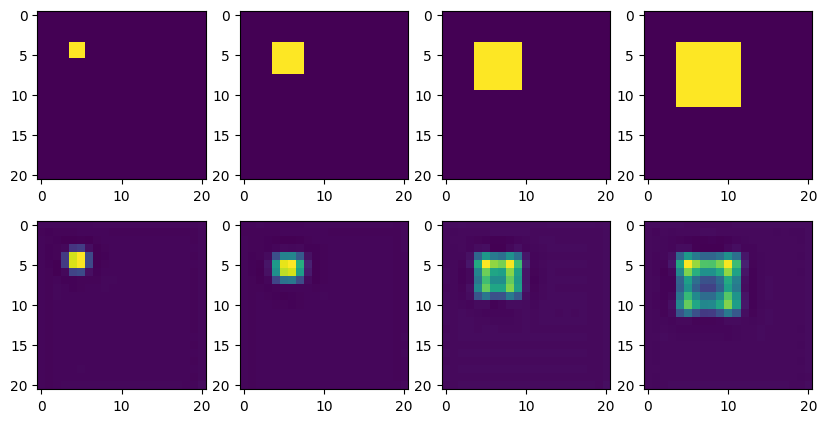

In [58]:
fig,ax=plt.subplots(nrows=2,ncols=4, figsize=(10,5))

for i in range(4):
    i_synth = np.zeros(21*21, dtype=np.float32).reshape(21,21)
    origin = 4,4
    size = 2*(i+1)
    bi = slice(origin[0],origin[0]+size), slice(origin[1],origin[1]+size)
    i_synth[bi] = 1
    
    i_synth_tensor = torch.from_numpy(i_synth).unsqueeze(0).unsqueeze(0)
    i_synth_pred = cnn_study["exec"](i_synth_tensor)
    ax[0][i].imshow(i_synth)
    ax[1][i].imshow(i_synth_pred[0][0].detach().numpy())

fig.savefig("synth_blobs.png", bbox_inches="tight")

# Analyse the magic

Add masks over showers and see if it's able to intelligently reconstruct what is behind the mask (saturated area).

Call it curtain test.